# Gaussian Discriminant Analysis
GDA models revolve around a modeling assumption that the <b>class-conditional</b> data distributions are multi-variate Gaussians, meaning that the distribution of each class is a MVN:

$$
p(x|y=c,\theta_c) \sim N(x|\mu_c,\Sigma_c)
$$

With this assumption, a classifier can be used which assigns a data vector to the class which has the maximum posterior probability for that vector:

$$
\begin{align}
\hat{y(x)} &= argmax_c [{Likelihood}_c*{Prior}_c] \\
           &= {argmax}_c [p(x|y=c,\theta_c)p(y=c,\theta_c)] \\
           &= {argmax}_c log[p(x|y=c,\theta_c)p(y=c,\theta_c)] \\
           &= {argmax}_c [log\ p(x|y=c,\theta_c) + log\ p(y=c,\theta_c)] \\
           &= {argmax}_c [log\ {Likelihood}_c + log\ {Prior}_c]
\end{align}
$$

#### Gaussian discriminant classifiers are distance-based classifiers
This might sound surprising, since many time a distinction is made in models as probabilistic vs geometric, parameteric vs non-parametric, etc. However, take a look at the definition of the MVN:

$$
\begin{align}
p(x|y=c,\theta_c) &\sim N(x|\mu_c,\Sigma_c) \\
                  &= \frac 1 {{(2\pi)}^{\frac D 2} {|\Sigma|^{\frac 1 2}}} e^{-\frac 1 2 {(x-\mu)}^T \Sigma^{-1} (x-\mu)}
\end{align}
$$

Since we are using an $argmax$ we can
1. use the logarithm, which will remove the exponential
2. drop constants, as they do not change the $argmax$ solution

$$
\begin{align}
    log\ p(x|y=c,\theta_c) &\sim -{(x-\mu_c)}^T \Sigma_c^{-1} (x-\mu_c) \\
                           &= -{(x-\mu_c)}^T (\sum_{i=1}^D \frac 1 {\lambda_i} u_i u_i^T) (x-\mu_c) \\
                           &= -\sum_{i=1}^D \frac 1 {\lambda_i} {(x-\mu_c)}^T u_i u_i^T (x-\mu_c) \\
                           &= -\sum_{i=1}^D \frac {y_i^2} {\lambda_i},\ y_i=\langle u_i, x-\mu_c\rangle
\end{align}
$$

In this light, we now see that the likelihood of the data vector $x$ under the MVN distribution is proportional to its inner products with the class's covariance eigenvectors, where the weights on the inner products are the MVN's precision coefficients (inverses of the covariance eigenvalues). Since the likelihood increases with proximity to the mean of the distribution, a Gaussian discriminant is also called a <b>nearest centroid classifier</b>.

We can then represent the classification decision as

$$
\hat{y_i} = argmin_c\ l(x, \mu_c) \\
l(x, \mu_c) = \sum_{i=1}^D \frac {{\langle u_i, x - \mu_c \rangle}^2} {\lambda_i}
$$

TODO ellipse plots

# Gaussian Quadratic Discriminant Analysis (G-QDA)

In G-QDA, we work with the data likelihood, conditioned on the class index. Recall, this modeling assumes that these class-conditional distributions are multivariate Gaussians. Also recall that, for $NC$ classes each indexed by $c$ and parametrized by $\theta_c$ vectors, the distribution can be written (via Bayes rule) as

$$
\begin{align}
    p(y_i=c_j|X,\theta) &= \frac {p(y_i=c_j|\theta)p(X|y_i=c_j,\theta)} {p(X|\theta)} \\
\end{align}
$$

The denominator $p(X, y_i=c_j|\theta)$ is simply a normalizing factor to make the resulting value a probability (in [0,1]). This can be expanded in terms of $X$ using the total probability rule to yield

$$
\begin{align}
    p(y_i=c_j|X,\theta) &= \frac {p(y_i=c_j|\theta)p(X|y_i=c_j,\theta)} {\sum_{k=1}^{NC} p(y_i=c_k|\theta)p(X|y_i=c_k,\theta)} \\
                        &= \frac {\pi_i N(x|\mu_i,\sigma_i)} {\sum_{k=1}^{NC} \pi_k N(x|\mu_k,\sigma_k)} \\
\end{align}
$$

In words, this says that, when handed a data set ($X$), the probability of a sample ($y_i$) belonging to a certain class ($c_i$) is equal to the ratio of the joint probability of 1) seeing that data set and 2) the sample belonging to that class (relative to the sum of all joint probabilities).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA,
)
%matplotlib inline

/Users/aagnone/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in divide
  S**2))[:self._max_components]


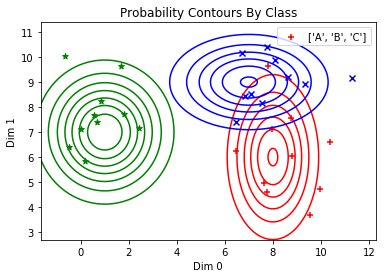

In [2]:
from numpy.linalg import inv, det
from numpy import dot, sum, exp, pi

N_CLASSES = 3
N_DIM = 2
N_SAMPLES = 10
colors = 'rgb'
markers = '+*x'

means = [
    np.random.randint(1, 10, N_DIM)
    for _ in range(N_CLASSES)
]
covs = [
    np.diag(np.random.randint(1, 4, N_DIM))
    for _ in range(N_CLASSES)
]
distros = [
    multivariate_normal(mean=means[i], cov=covs[i])
    for i in range(N_CLASSES)
]
X_all = [
    distros[i].rvs(N_SAMPLES)
    for i in range(N_CLASSES)
]
y_all = [
    (np.ones(shape=N_SAMPLES) * i).astype(int)
    for i in range(N_CLASSES)
]
class_names = [
    chr(ord('A') + i)
    for i in range(N_CLASSES)
]


def mvn2d(x, y, mu, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_inv = inv(sigma)
    centered = xy - mu
    z = dot(centered, sigma_inv)
    z = sum(z * centered, axis=1)
    z = exp(-0.5 * z) / 1. / (2. * pi * det(sigma ** 0.5))
    return z.reshape(xx.shape)

data = np.vstack(X_all)
x_min, y_min = data.min(axis=0)
x_max, y_max = data.max(axis=0)
x_range = np.linspace(x_min - 1, x_max + 1, 200)
y_range = np.linspace(y_min - 1, y_max + 1, 200)
xx, yy = np.meshgrid(x_range, y_range)

for i in range(N_CLASSES):
    X, y = X_all[i], y_all[i]
    plt.scatter(X[:, 0], X[:, 1], color=colors[i], marker=markers[i])
    lda = LDA().fit(X, y)
    
    z = mvn2d(x_range, y_range, means[i], covs[i])
    plt.contour(xx, yy, z, colors=colors[i])
    
plt.xlabel('Dim 0'); plt.ylabel('Dim 1')
plt.title('Probability Contours By Class')
plt.legend([class_names])


# Gaussian Linear Discriminant Analysis (G-LDA)

G-LDA is just a special case of G-QDA, where we take a modeling assumption that the covariance matrices of each class is equal. In this case, we call the covariance matrices <b>tied</b>, and the posterior representation simplifies. The reason that <b>linear</b> is in the name will become clear after working through the posterior representation. Since the covariance matrices are equal, $\Sigma_c = \Sigma$ and

\begin{align}
    p(y=c|x,\theta) &\propto \pi_c\ exp({\mu_c}^T{\Sigma^{-1}}x - \frac 1 2 x^T {\Sigma}^{-1} x - \frac 1 2 {\mu_c}^T {\Sigma^{-1}}\mu_c) \\
                    &= exp(log{\pi_c})\ exp({\mu_c}^T{\Sigma^{-1}}x - \frac 1 2 x^T {\Sigma}^{-1} x - \frac 1 2 {\mu_c}^T {\Sigma^{-1}}\mu_c) \\
                    &= exp({\mu_c}^T{\Sigma^{-1}}x - \frac 1 2 x^T {\Sigma}^{-1} x - \frac 1 2 {\mu_c}^T {\Sigma^{-1}}\mu_c + log{\pi_c}) \\
                    &= exp({\mu_c}^T{\Sigma^{-1}}x - \frac 1 2 {\mu_c}^T {\Sigma^{-1}}\mu_c + log{\pi_c})\ exp(- \frac 1 2 x^T {\Sigma}^{-1} x )
\end{align}

Since the second $exp$ term in the last line does not depend on the class $c$, it will cancel in the expression $\frac {p(y_i=c_j|\theta)p(X|y_i=c_j,\theta)} {\sum_{k=1}^{NC} p(y_i=c_k|\theta)p(X|y_i=c_k,\theta)}$, yielding the following:

\begin{align}
    p(y_i=c_j|x,\theta) &= \frac {\pi_j p(X|y_i=c_j,\theta)} {\sum_{k=1}^{NC} \pi_k p(X|y_i=c_k,\theta)} \\
                    &= \frac {exp({\mu_j}^T{\Sigma^{-1}}x - \frac 1 2 {\mu_j}^T {\Sigma^{-1}}\mu_j + log{\pi_j})} {\sum_{k=1}^{NC} exp({\mu_k}^T{\Sigma^{-1}}x - \frac 1 2 {\mu_k}^T {\Sigma^{-1}}\mu_k + log{\pi_k})} \\
                    &= \frac {exp(\alpha_c x + \beta_c)} {\sum_{k=1}^{NC} exp(\alpha_k x + \beta_k)}
\end{align}

\begin{align}
    \alpha_c &= {\mu_c}^T \Sigma^{-1} \\
    \beta_c &= - \frac 1 2 {\mu_c}^T {\Sigma^{-1}}\mu_c + log{\pi_c}
\end{align}

With the above change of variables, the class posteriors become softmax functions of the $\mu_c, \Sigma_c$. But why is it referred to as a <b>linear</b> discriminant? To see this, take the logarithm of the posterior. We'll use the 2-class case for simplicity.

\begin{align}
    p(y_i=c_0|x,\theta) &= \frac {exp(\alpha_0^T x + \beta_0)} {exp(\alpha_0^T x + \beta_0) + exp(\alpha_1^T x + \beta_1)} \\
    log\{p(y_i=c_j|x,\theta)\} &= \frac {\alpha_0^T x + \beta_0} {\alpha_0^T x + \beta_0 + \alpha_1^T x + \beta_1}
\end{align}

This log posterior representation is a linear function of $x$. Since the decision boundary of the discriminant is the location where the posteriors for the two classes are equal, we can derive the line's parameters as follows:

\begin{align}
    p(y_i=c_j|x,\theta) &= p(y_i=c_k|x,\theta) \\
    log\{p(y_i=c_j|x,\theta)\} &= log\{p(y_i=c_k|x,\theta)\} \\
    \alpha_j^T x + \beta_j &= \alpha_k^T x + \beta_k \\\\
    f_{decision} &= (\alpha_j - \alpha_k)^T x  - (\beta_k - \beta_j) \\
                 &= w^T (x - x_0) \\
               w &= \Sigma^{-1} (\mu_1 - \mu_0) \\
             x_0 &= \frac 1 2(\mu_1 - \mu_0) - (\mu_1 - \mu_0) \frac {log\{\frac {\pi_1} {\pi_0} \}} {(\mu_1 - \mu_0)^T\Sigma^{-1}(\mu_1 - \mu_0)}
\end{align}